#### Pytorch Unet  

#### 1.相關模組

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader,Subset,Dataset
from torchvision import transforms
from tqdm import tqdm
from pathlib import Path

from sklearn.model_selection import KFold

from PIL import Image
import cv2
import os

from unet import UNet
from utils.data_loading import CarvanaDataset,BasicDataset
from utils.dice_score import dice_loss

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 2.參數設定

In [2]:
epochs = 1
batch_size = 2
lr = 1e-5
scale = 0.2
classes = 2
dir_img = Path('/workspace/Unet/bad/image')
dir_mask = Path('/workspace/Unet/bad/label')
kfold = KFold(n_splits=4)

#### 3.GPU(CUDA)

In [3]:
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

True


#### 4.Unet 模型

In [4]:
model = UNet(n_channels=3, n_classes=classes)
model.to(device=device)
torch.save(model.state_dict(), "init.pth")
criterion = nn.CrossEntropyLoss()

#### 5.資料集讀入

In [5]:
try:
    dataset = CarvanaDataset(dir_img, dir_mask, scale= 1)
except (AssertionError, RuntimeError, IndexError):
    dataset = BasicDataset(dir_img, dir_mask, scale= 1)


100%|██████████| 200/200 [00:00<00:00, 447.25it/s]


#### 6.4Fold資料分割、模型訓練及驗證 

In [8]:
dice2Arr=[]
diceArr=[]
for fold, (train_num, val_num) in enumerate(kfold.split(dataset)):
    model.load_state_dict(torch.load("init.pth"))   
    print("Fold :{} ".format(fold+1))
 
    train_data_set = Subset(dataset,train_num)      
    valida_data_set = Subset(dataset,val_num)

    train_loader = DataLoader(train_data_set, batch_size = batch_size)
    valida_loader = DataLoader(valida_data_set, batch_size = batch_size)
  

    optimizer = optim.RMSprop(model.parameters(),lr=lr,weight_decay= 1e-8, momentum=0.999)
    for epoch in range(epochs):
        # Training
        model.train()
        for per_batch in tqdm(train_loader,desc=f'Epoch {epoch+1}/{epochs}',unit='img'):
            images, true_masks = per_batch['image'], per_batch['mask']
            images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            true_masks = true_masks.to(device=device, dtype=torch.long)
            masks_pred = model(images)
            loss = criterion(masks_pred, true_masks)
            loss += dice_loss(F.softmax(masks_pred, dim=1).float(),F.one_hot(true_masks, model.n_classes).permute(0, 3, 1, 2).float(),multiclass=True)
            optimizer.zero_grad() 
            loss.backward() 
            optimizer.step()


        # Validation
        model.eval()
        with torch.no_grad():
            dice_score = 0
            for per_batch in tqdm(valida_loader,desc=f'Validation'):
                images, true_masks = per_batch['image'], per_batch['mask']
                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                true_masks = true_masks.to(device=device, dtype=torch.long)
                masks_pred = model(images)
                dice_score += dice_loss(F.softmax(masks_pred, dim=1).float(),F.one_hot(true_masks, model.n_classes).permute(0, 3, 1, 2).float(),multiclass=True)
            
            print('Validation Dice score: {}'.format(dice_score/max(len(valida_loader),1)))
            diceArr.append(dice_score/max(len(valida_loader),1))



    state_dict = model.state_dict()
    torch.save(state_dict, str('./weight/Fold_{}.pth'.format(fold)))


Fold :1 


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.37it/s]


Validation Dice score: 0.21526740491390228
Fold :2 


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.74it/s]


Validation Dice score: 0.20728270709514618
Fold :3 


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.96it/s]


Validation Dice score: 0.14831729233264923
Fold :4 


Validation: 100%|██████████| 25/25 [00:03<00:00,  6.47it/s]


Validation Dice score: 0.2994658350944519


In [20]:
for index,(i) in enumerate(diceArr):
    print("Fold : %d \nDice Score : %.3f" %(index+1,i.cpu().numpy()))
    

Fold : 1 
Dice Score : 0.215
Fold : 2 
Dice Score : 0.207
Fold : 3 
Dice Score : 0.148
Fold : 4 
Dice Score : 0.299


#### 7.模型預測結果

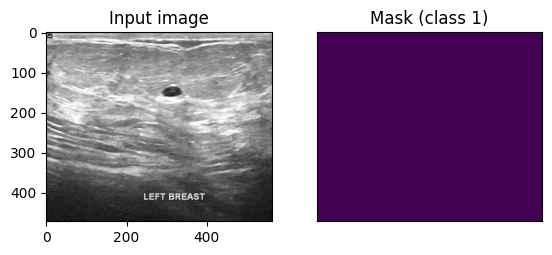

In [ ]:
from utils.data_loading import BasicDataset
import matplotlib.pyplot as plt
from PIL import Image



# Predict
net = UNet(n_channels=3, n_classes=2 , bilinear = False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


net.to(device=device)
state_dict = torch.load('./weight/Fold_2.pth', map_location=device)



net.load_state_dict(state_dict)



full_img = Image.open("./good/image/benign (1).png")



net.eval()
img = torch.from_numpy(BasicDataset.preprocess(None, full_img, scale, is_mask=False))
img = img.unsqueeze(0)
img = img.to(device=device, dtype=torch.float32)



with torch.no_grad():
    output = net(img).cpu()
    output = F.interpolate(output, (full_img.size[1], full_img.size[0]), mode='bilinear')
    mask = output.argmax(dim=1)
    mask = mask[0].long().squeeze().numpy()



classes = mask.max() + 1
fig, ax = plt.subplots(1, classes + 1)
ax[0].set_title('Input image')
ax[0].imshow(full_img)
for i in range(classes):
    ax[i + 1].set_title(f'Mask (class {i + 1})')
    ax[i + 1].imshow(mask == i)
plt.xticks([]), plt.yticks([])
plt.show()

